In [16]:
import pandas as pd
import copy
import sys

from LAB3_1.utils import show_loss, show_result

from tqdm import tqdm
from itertools import product
from typing import Tuple

import numpy as np
from numpy import ndarray, expand_dims, hstack, zeros

from torch import Tensor, no_grad, zeros, from_numpy, cuda
from torch.nn import Module, Sequential, Linear, MSELoss, RNN
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'

## Model

In [3]:
class RecurrentNN(Module): # Recurrent Neural network
    def __init__(self, hidden:int, layers:int, no_linearity:str="relu"):
        super(RecurrentNN,self).__init__()

        self.hidden_size = hidden
        self.layers = layers

        self.rnn = RNN(1, hidden_size=hidden, num_layers=layers,
                       nonlinearity=no_linearity, batch_first=True)

        self.read_out = Sequential(Linear(hidden, 1))
        self.criteria = MSELoss() # Mean square error loss

        self.last_hidden = None

    def forward(self, x:Tensor, y:Tensor=None, save_state:bool=False):
        self.rnn.flatten_parameters()
        output, hn = self.rnn(x, self.last_hidden)
        y_pred = self.read_out(output)

        if save_state:
            self.last_hidden = hn.detach()

        loss = None
        if y is not None:
            loss = self.criteria(y_pred, y)
        return (loss, y_pred) if loss is not None else y_pred

## Trainer

In [4]:
class RNN_trainer:
    def __init__(self, hidden:int, layers:int, no_linearity:str):

        # model
        self.model = RecurrentNN(hidden=hidden, layers=layers, no_linearity=no_linearity).to(device)

    def fit(self, df:ndarray, epochs:int=2, lr:float=0.001)->Tensor:
        df = from_numpy(df).float().contiguous().to(device)

        opt = Adam(self.model.parameters(), lr)
        history_tr = zeros(epochs) # Keep track the behavior of loss

        self.model.train()
        for i in range(epochs):

            opt.zero_grad(set_to_none=True)
            loss, _ = self.model(df[0], df[1])
            loss.backward()
            clip_grad_norm_(self.model.parameters(), 1.5)
            opt.step()

            # save the current loss
            history_tr[i] = loss.item()
        return history_tr  # return the history of loss

    def validate(self, df:ndarray, save_state:bool=False) -> Tuple:
        # Given a validation dataset, it performs the loss
        df = from_numpy(df).float().contiguous().to(device)
        return  self.predict(df[0], df[1], save_state) + (df[1],)

    def predict(self, x:Tensor, y:Tensor=None, save_state:bool=False):
        """
        If the target it is provided, the method performs also the loss, otherwise
        return only the output of the network.
        """
        self.model.eval()
        with no_grad():
            return  self.model(x, y, save_state)

In [5]:
class GridSearch:

    def __init__(self, parameters_grid:dict, tr:ndarray, dev:ndarray):

        all_configs = [dict(zip(parameters_grid.keys(), configs)) for configs in product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))
        # returns the performance in each configuration, the best model and the history of the loss
        rank, best, loss = self.run(tr, dev, all_configs)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best
        self.tr_loss = loss

    @staticmethod
    def run(tr:ndarray, dev:ndarray, configs:list):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # the keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss during the epochs
        best, loss = None, None
        best_dev_loss = sys.maxsize

        for config in tqdm(configs):

            trainer = RNN_trainer(hidden=config["units"],
                                  layers=config["layers"],
                                  no_linearity=config["activ"])

            history = trainer.fit(tr, config["epochs"], config["lr"])
            vl_loss = trainer.validate(dev)[0].item()

            rank.append((config, round(history[-1].item(), 6), round(vl_loss, 6)))

            # we keep the best model
            if best_dev_loss > vl_loss:
                best_dev_loss = vl_loss
                loss = copy.deepcopy(history)
                best = copy.deepcopy(trainer)

        return rank, best, loss

# Assignment 1.1: NARMA10 task with RNN

## Retrieve the dataset

In [6]:
source1 = pd.read_csv("./sources/NARMA10.csv", header=None).T.to_numpy()
source2 = pd.read_csv("./sources/MG17.csv", header=None).T.to_numpy()

## Hold-out

In [7]:
source1 = expand_dims(source1.T, axis=-1)
tr_dataset, dev_dataset, ts_dataset = source1[:,:4000], source1[:,4000:5000], source1[:,5000:]

## Grid search

In [8]:
ranges_to_explore = {
    "units" : [100, 200, 500],
    "epochs" : [500, 800],
    "lr" : [0.003, 0.008, 0.01],
    "layers": [1],
    "activ" : ["relu"]
}

gs = GridSearch(ranges_to_explore,tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

Number of configurations to try:  18


100%|██████████| 18/18 [15:25<00:00, 51.42s/it] 


The best solution in  ({'units': 200, 'epochs': 800, 'lr': 0.003, 'layers': 1, 'activ': 'relu'}, 0.000253, 0.000474)


## Training loss

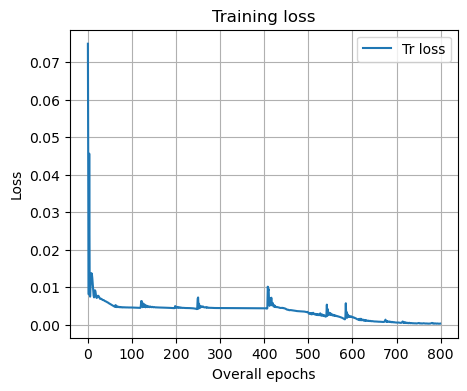

In [9]:
show_loss(gs.tr_loss)

## Train, Validation and Test errors in the best configuration

In [10]:
tr_loss = best_model.validate(tr_dataset, save_state=True)[0]
print("Train Error", round(tr_loss.item(), 6))

dev_loss = best_model.validate(dev_dataset)[0]
print("Validation Error", round(dev_loss.item(), 6))

test_loss = best_model.validate(ts_dataset)[0]
print("Test Error", round(test_loss.item(), 6))

Train Error 0.000242
Validation Error 0.000264
Test Error 0.00028


C:\Users\Andrea\anaconda3\envs\GeneralPurpose\lib\site-packages\torch\nn\modules\rnn.py:513: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_relu(input, hx, self._flat_weights, self.bias, self.num_layers,


## Final retrain with Training and Validation set (with the best configuration)

In [11]:
final_trainer = RNN_trainer(hidden=best_config["units"],
                            layers=best_config["layers"],
                            no_linearity=best_config["activ"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = hstack([tr_dataset, dev_dataset])
tr_history = final_trainer.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_y_pred, tr_y = final_trainer.validate(final_tr)
print("Training Error", round(tr_loss.item(), 6))

test_loss, ts_y_pred, test_y  = final_trainer.validate(ts_dataset)
print("Test Error", round(test_loss.item(), 6))

Validation Error 0.00021
Test Error 0.000286


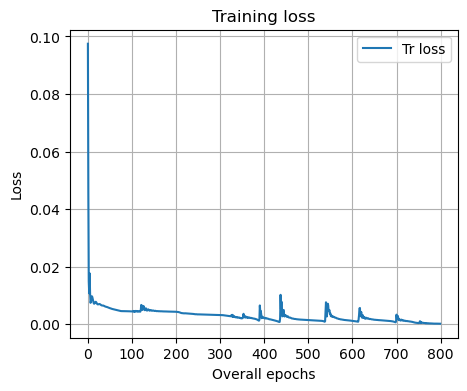

In [12]:
show_loss(tr_history)

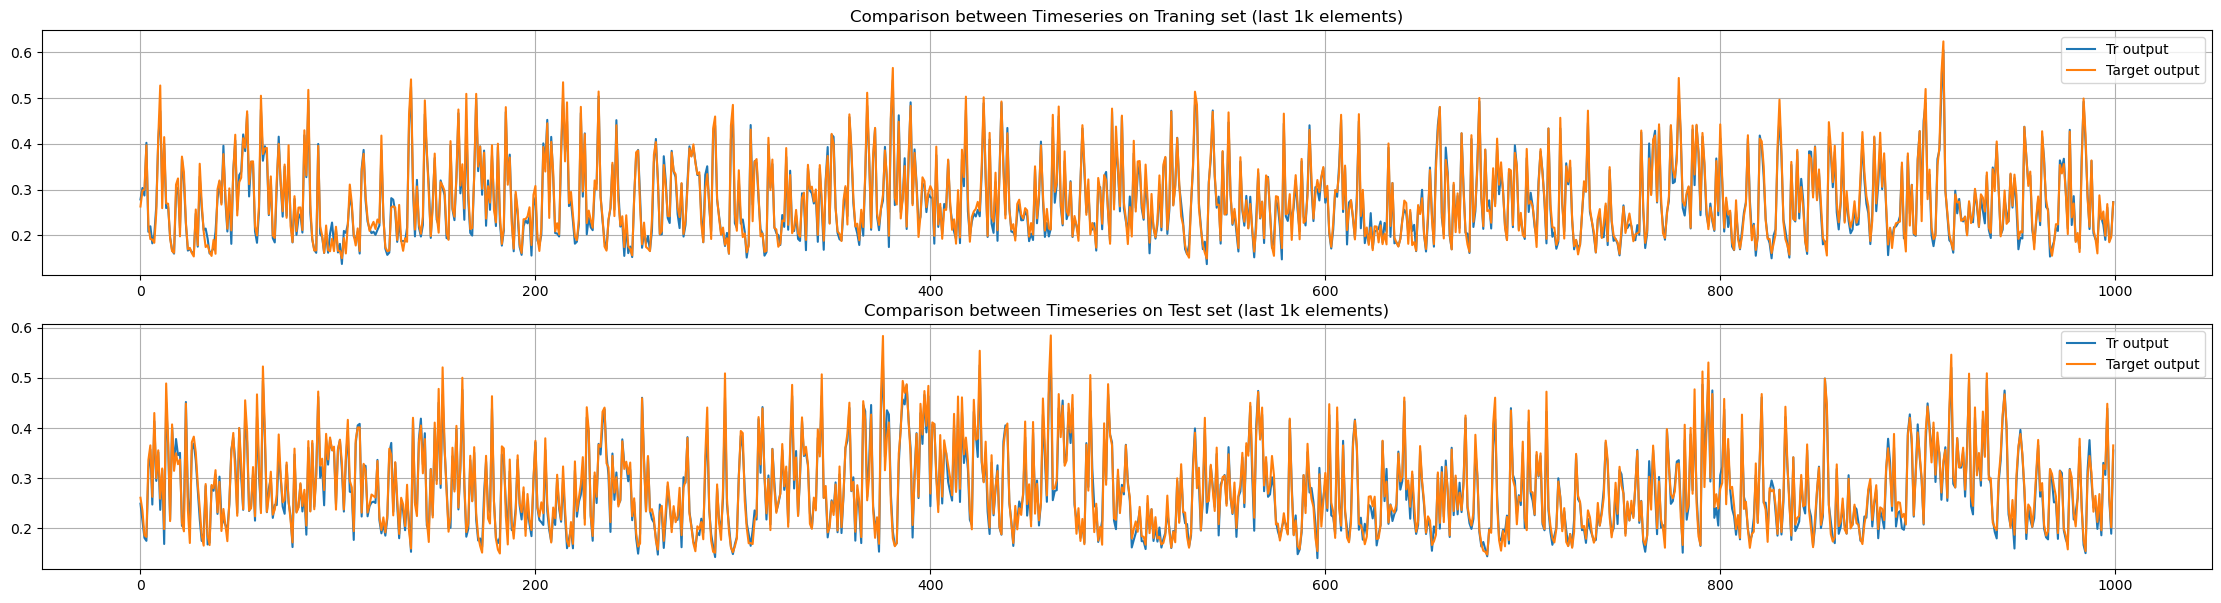

In [13]:
show_result(tr_y_pred, tr_y, ts_y_pred, test_y)

# Bonus-track Assignment 1: Mackey-Glass 17 task with RNN

## Hold out

In [17]:
source_aligned = np.zeros((2, source2.shape[0]-1, 1))
source_aligned[0], source_aligned[1] = source2[:-1], source2[1:]
tr_dataset, dev_dataset, ts_dataset = source_aligned[:,:4000], source_aligned[:,4000:5000], source_aligned[:,5000:]

## Grid search

In [18]:
ranges_to_explore = {
    "units" : [100, 200, 500],
    "epochs" : [500, 800],
    "lr" : [0.003, 0.008, 0.01],
    "layers": [1],
    "activ" : ["relu"]
}

gs = GridSearch(ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

Number of configurations to try:  18


100%|██████████| 18/18 [14:50<00:00, 49.49s/it] 


The best solution in  ({'units': 200, 'epochs': 500, 'lr': 0.01, 'layers': 1, 'activ': 'relu'}, 1.3e-05, 0.000391)


## Training loss

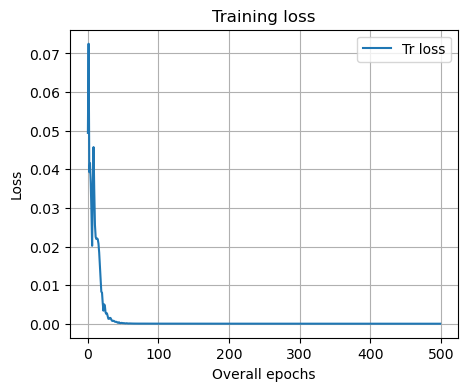

In [19]:
show_loss(gs.tr_loss)

## Train, Validation and Test errors in the best configuration

In [20]:
tr_loss = best_model.validate(tr_dataset, save_state=True)[0]
print("Train Error", round(tr_loss.item(), 6))

dev_loss = best_model.validate(dev_dataset)[0]
print("Validation Error", round(dev_loss.item(), 6))

test_loss = best_model.validate(ts_dataset)[0]
print("Test Error", round(test_loss.item(), 6))

Train Error 1.4e-05
Validation Error 1.4e-05
Test Error 0.000111


C:\Users\Andrea\anaconda3\envs\GeneralPurpose\lib\site-packages\torch\nn\modules\rnn.py:513: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_relu(input, hx, self._flat_weights, self.bias, self.num_layers,


## Final retrain with Training and Validation set (with the best configuration)

In [21]:
final_trainer = RNN_trainer(hidden=best_config["units"],
                            layers=best_config["layers"],
                            no_linearity=best_config["activ"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = hstack([tr_dataset, dev_dataset])
tr_history = final_trainer.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_y_pred, tr_y = final_trainer.validate(final_tr)
print("Training Error", round(tr_loss.item(), 6))

test_loss, ts_y_pred, test_y  = final_trainer.validate(ts_dataset)
print("Test Error", round(test_loss.item(), 6))

Training Error 1e-05
Test Error 4.5e-05


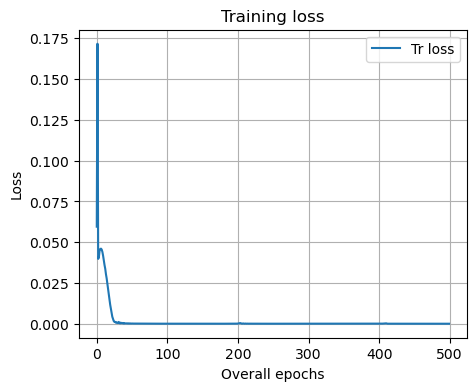

In [22]:
show_loss(tr_history)

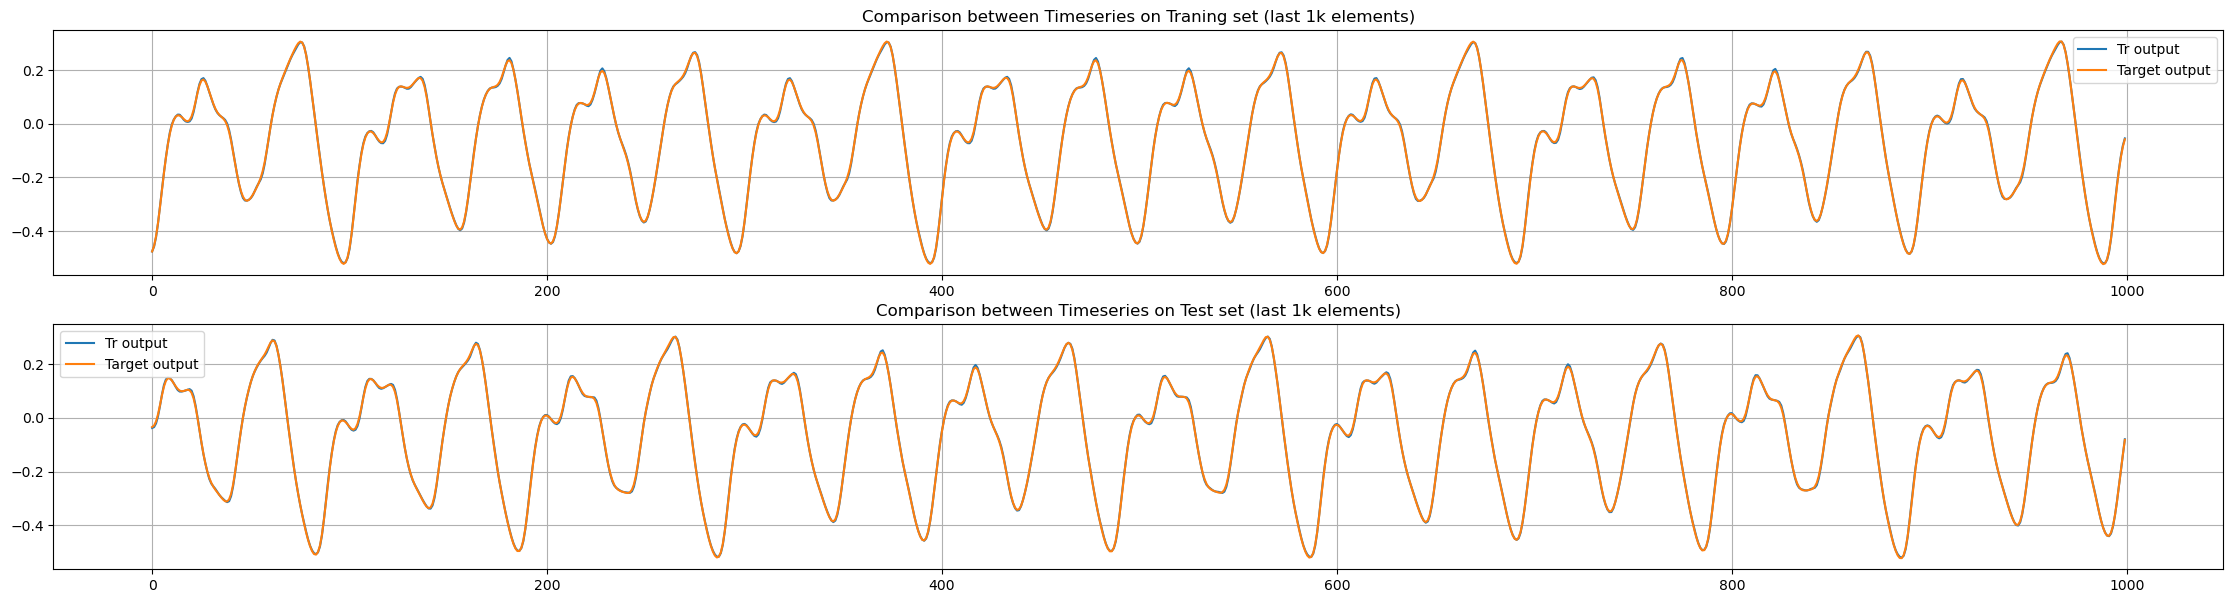

In [23]:
show_result(tr_y_pred, tr_y, ts_y_pred, test_y)